In [1]:
# import numpy as np, matplotlib.pyplot as plt
# from pathlib import Path

# def beta_scaled(rng, shape, a, b, lo, hi):
#     z = rng.beta(a, b, size=shape)
#     return lo + z*(hi-lo)

# def sample_instance(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10):
#     probs = rng.dirichlet(np.ones(S)*tau)
#     mc = rng.uniform(lo, hi, size=G)
#     mv = rng.uniform(lo, hi, size=D)
#     is_tail = np.zeros(S, dtype=bool)

#     if scenario=="s_1":
#         g = rng.uniform(lo, hi, size=(S,G))
#         d = rng.uniform(lo, hi, size=(S,D))

#     elif scenario=="s_2":
#         g = beta_scaled(rng, (S,G), 0.4, 4.0, lo, hi)
#         d = rng.uniform(lo, hi, size=(S,D))

#     elif scenario=="s_3":
#         g = rng.uniform(lo, hi, size=(S,G))
#         d = beta_scaled(rng, (S,D), 4.0, 0.4, lo, hi)

#     elif scenario=="s_4":
#         g = beta_scaled(rng, (S,G), 0.8, 3.0, lo, hi)
#         d = beta_scaled(rng, (S,D), 3.0, 0.8, lo, hi)
#         is_tail = rng.random(S) < eps
#         shrink = rng.uniform(0.05, 0.30, size=(S,1))
#         blow   = rng.uniform(1.20, 1.80, size=(S,1))
#         g = np.where(is_tail[:,None], g*shrink, g)
#         d = np.where(is_tail[:,None], d*blow, d)
#         g = np.clip(g, lo, hi); d = np.clip(d, lo, hi)

#     elif scenario=="s_5":
#         probs = rng.dirichlet(np.ones(S)*tau)
#         mc = rng.uniform(lo, hi, size=G)
#         mv = rng.uniform(lo, hi, size=D)
#         inter = rng.random(G) < 0.30
#         a_g = np.where(inter, 0.5, 3.0); b_g = np.where(inter, 4.0, 3.0)
#         g = lo + rng.beta(a_g, b_g, size=(S,G))*(hi-lo)
#         d = beta_scaled(rng, (S,D), 3.0, 3.0, lo, hi)

#     else:
#         raise ValueError("unknown scenario")
#     return probs, mc, mv, g, d, {"is_tail":is_tail}

# def plot_probs(probs, title, out):
#     plt.figure(figsize=(6,3)); plt.bar(np.arange(len(probs)), probs); plt.title(title); plt.xlabel("scenario"); plt.ylabel("prob"); plt.tight_layout(); plt.savefig(out); plt.show()

# def plot_hist(x, title, out, bins=40):
#     plt.figure(figsize=(6,3)); plt.hist(x.ravel(), bins=bins); plt.title(title); plt.xlabel("value"); plt.ylabel("freq"); plt.tight_layout(); plt.savefig(out); plt.show()

# def plot_supply_demand_scatter(g, d, title, out, is_tail=None):
#     gsum = g.sum(1); dsum = d.sum(1)
#     plt.figure(figsize=(4,4))
#     if is_tail is None or is_tail.sum()==0:
#         plt.scatter(gsum, dsum)
#     else:
#         idx0 = ~is_tail; idx1 = is_tail
#         plt.scatter(gsum[idx0], dsum[idx0], label="normal")
#         plt.scatter(gsum[idx1], dsum[idx1], marker="x", label="stress")
#         plt.legend()
#     plt.title(title); plt.xlabel("total supply cap"); plt.ylabel("total demand cap"); plt.tight_layout(); plt.savefig(out); plt.show()

# def visualize_scenario(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10, outdir=Path("figures")):
#     outdir.mkdir(parents=True, exist_ok=True)
#     probs, mc, mv, g, d, extras = sample_instance(rng, scenario, S,G,D,lo,hi,tau,eps)
#     tag = f"{scenario}_S{S}_G{G}_D{D}"
#     plot_probs(probs, f"{scenario}: scenario probabilities", outdir/f"{tag}_probs.png")
#     plot_hist(g, f"{scenario}: generator caps", outdir/f"{tag}_g_hist.png")
#     plot_hist(d, f"{scenario}: demand caps", outdir/f"{tag}_d_hist.png")
#     plot_supply_demand_scatter(g, d, f"{scenario}: per-scenario totals", outdir/f"{tag}_totals.png", extras.get("is_tail"))

# if __name__=="__main__":
#     rng = np.random.default_rng(123)
#     scenarios = ["s_1","s_2","s_3","s_4","s_5"]
#     for sc in scenarios:
#         visualize_scenario(rng, sc, S=30, G=20, D=20, lo=1.0, hi=100.0, tau=1.0, eps=0.10)

Helper Methods for generating instances

In [2]:
# import jax, jax.numpy as jnp
# from jax import random
# from pathlib import Path

# # def beta_scaled(rng, shape, a, b, lo, hi):
# #     """Generate beta-distributed random numbers scaled to [lo, hi] range."""
# #     z = random.beta(rng, a, b, shape=shape)
# #     return lo + z * (hi - lo)
    
# # def lognormal_trunc(key, shape, mu=0.0, sigma=0.9, lo=1.1, hi=8.0):
# #     z = random.normal(key, shape)
# #     x = jnp.exp(mu + sigma*z)
# #     return jnp.clip(x, lo, hi)

# # def beta_to_interval(key, shape, a, b, lo, hi):
# #     z = random.beta(key, a, b, shape=shape)
# #     return lo + z*(hi-lo)

# def truncated_lognormal(rng, shape, mean, sigma, lo, hi):
#     x = rng.lognormal(mean, sigma, size=shape)
#     x = np.clip(x, lo, hi)
#     return x


# def generate_instance(key, num_scenarios = 10, num_g = 10, num_d = 10, minval = 1, maxval = 100):
#     input_scenario = "s_2"

#     if input_scenario == "s_1":
#         # Sid's original synthetic case with uniform distribution
#         probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
#         probs = random.dirichlet(probs_key, jnp.ones(num_scenarios))
#         mc_g_i = random.uniform(mc_key, (num_g,), minval=minval, maxval=maxval)
#         mv_d_j = random.uniform(mv_key, (num_d,), minval=minval, maxval=maxval)
#         g_i_bar = random.uniform(g_key, (num_scenarios, num_g), minval=minval, maxval=maxval)
#         d_j_bar = random.uniform(d_key, (num_scenarios, num_d), minval=minval, maxval=maxval)
        
#     elif input_scenario == "s_2":
#         probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
#         probs = random.dirichlet(probs_key, jnp.ones(num_scenarios))
#         mc_g_i = random.uniform(mc_key, (num_g,), minval=minval, maxval=maxval)
#         mv_d_j = random.uniform(mv_key, (num_d,), minval=minval, maxval=maxval)
#         # g_i_bar = random.uniform(g_key, (num_scenarios, num_g), minval=minval, maxval=maxval)
#         # d_j_bar = random.uniform(d_key, (num_scenarios, num_d), minval=minval, maxval=maxval)

#         g_i_bar = 100 - truncated_lognormal(key, (num_scenarios, num_g), mean=3, sigma=1.0, lo=1, hi=100)
#         d_j_bar = truncated_lognormal(key, (num_scenarios, num_d), mean=3, sigma=1.0, lo=1, hi=100)

#     # elif input_scenario == "s_3":
#     #     # Demand-surge tails: demand caps right-heavy (more mass near max)
#     #     # Beta(a>1,b<1). Gen caps remain uniform.
#     #     probs_key, mc_key, mv_key, g_key, d_key = random.split(key, 5)
#     #     probs = random.dirichlet(probs_key, jnp.ones(num_scenarios))
#     #     mc_g_i = random.uniform(mc_key, (num_g,), minval=minval, maxval=maxval)
#     #     mv_d_j = random.uniform(mv_key, (num_d,), minval=minval, maxval=maxval)
#     #     g_i_bar = random.uniform(g_key, (num_scenarios, num_g), minval=minval, maxval=maxval)
#     #     d_j_bar = beta_scaled(d_key, (num_scenarios, num_d), a=4.0, b=0.4, lo=minval, hi=maxval)

#     # elif input_scenario == "s_4":
#     #     # Supply shortage + demand surge, tuned for heavy tails in E[-SS]
#     #     # Keys
#     #     (probs_key, mc_key, mv_key, g_key, d_key,
#     #     t_key, k_shrink, k_blow, z_key, size_key) = random.split(key, 10)

#     #     S, G, D = num_scenarios, num_g, num_d

#     #     # Prices (optionally keep as before)
#     #     mc_g_i = random.uniform(mc_key, (G,), minval=minval, maxval=maxval)
#     #     mv_d_j = random.uniform(mv_key, (D,), minval=minval, maxval=maxval)

#     #     # --- Heterogeneous unit sizes (few big gens) ---------------------------
#     #     # Draw positive weights, normalize, then scale by maxval for baseline caps
#     #     gen_size = jnp.exp(0.8 * random.normal(size_key, (G,)))  # lognormal-ish
#     #     gen_size = gen_size / gen_size.mean()

#     #     # --- Baseline (non-stressed) caps: mildly skewed already ---------------
#     #     g_base = beta_scaled(g_key, (S, G), a=0.6, b=3.2, lo=minval, hi=maxval) * gen_size
#     #     d_base = beta_scaled(d_key, (S, D), a=3.2, b=0.6, lo=minval, hi=maxval)

#     #     # --- Mark stressed scenarios -------------------------------------------
#     #     eps = 0.10  # expected fraction stressed
#     #     is_tail = random.bernoulli(t_key, eps, (S,))

#     #     # --- Heavy-tailed multipliers ------------------------------------------
#     #     # Deep shrink: concentrate near 0 with Beta(0.25, 3.5) mapped to [0.0, 0.30]
#     #     shrink01 = random.beta(k_shrink, a=0.25, b=3.5, shape=(S,1))
#     #     shrink   = 0.30 * shrink01  # [~0, 0.30]

#     #     # Big blow-ups: lognormal with fat right tail, truncated
#     #     blow = lognormal_trunc(k_blow, (S,1), mu=0.25, sigma=0.9, lo=1.2, hi=8.0)

#     #     # Apply stress (shrink gen, blow up demand)
#     #     g_i_bar = jnp.where(is_tail[:, None], g_base * shrink, g_base)
#     #     d_j_bar = jnp.where(is_tail[:, None], d_base * blow,   d_base)

#     #     # IMPORTANT: allow near-zero generation; cap only at upper bound
#     #     g_i_bar = jnp.clip(g_i_bar, 0.0, maxval)
#     #     # Let demand blow go well above the old hi; optionally raise maxval for demand
#     #     d_j_bar = jnp.clip(d_j_bar, 0.0, maxval * 8.0)

#     #     # --- Spiky, tail-biased scenario probabilities -------------------------
#     #     base_alpha = 0.05
#     #     tail_alpha = 0.30
#     #     alpha = jnp.where(is_tail, tail_alpha, base_alpha)  # stressed scenarios favored
#     #     probs = random.dirichlet(probs_key, alpha)

#     #     # Rare catastrophe: push extra mass onto stressed scenarios
#     #     zeta = random.beta(z_key, a=0.2, b=1.0)  # often large
#     #     tail_mask = is_tail.astype(jnp.float32)
#     #     tail_count = jnp.maximum(tail_mask.sum(), 1.0)
#     #     probs = (1.0 - zeta) * probs + zeta * (tail_mask / tail_count)
    
#     # elif input_scenario == "s_5":
#     #     # Correlated extremes: in a small ε share of scenarios, shrink demand & blow up gen
#     #     probs_key, mc_key, mv_key, g_key, d_key, t_key, k_shrink, k_blow = random.split(key, 8)
#     #     probs = random.dirichlet(probs_key, jnp.ones(num_scenarios))
#     #     mc_g_i = random.uniform(mc_key, (num_g,), minval=minval, maxval=maxval)
#     #     mv_d_j = random.uniform(mv_key, (num_d,), minval=minval, maxval=maxval)
#     #     # mild heavy-tails even outside stress
#     #     g_i_bar = beta_scaled(g_key, (num_scenarios, num_g), a=3.0, b=0.8, lo=minval, hi=maxval)
#     #     d_j_bar = beta_scaled(d_key, (num_scenarios, num_d), a=0.8, b=3.0, lo=minval, hi=maxval)
#     #     # mark tail scenarios
#     #     eps = 0.10  # fraction stressed
#     #     is_tail = random.bernoulli(t_key, eps, (num_scenarios,))
#     #     # scenario-level stress multipliers
#     #     shrink = random.uniform(k_shrink, (num_scenarios, 1), minval=0.05, maxval=0.30)  # 5–30% of base
#     #     blow   = random.uniform(k_blow,   (num_scenarios, 1), minval=1.20, maxval=1.80)  # 120–180% of base
#     #     g_i_bar = jnp.where(is_tail[:, None], g_i_bar * blow, g_i_bar)
#     #     d_j_bar = jnp.where(is_tail[:, None], d_j_bar * shrink,   d_j_bar)
#     #     # keep within declared bounds
#     #     g_i_bar = jnp.clip(g_i_bar, minval, maxval)
#     #     d_j_bar = jnp.clip(d_j_bar, minval, maxval)

#     # else:
#     #     raise ValueError(f"Unknown input_scenario: {input_scenario}")

#     return probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar

# # Adapter: keep the notebook API, call your JAX generator, return NumPy
# def sample_instance(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10):
#     if isinstance(rng, np.random.Generator):
#         seed = int(rng.integers(0, np.uint32(2**32 - 1), dtype=np.uint32))
#         key = random.PRNGKey(seed)
#     elif isinstance(rng, (int, np.integer)):
#         key = random.PRNGKey(int(rng))
#     elif isinstance(rng, jax.Array):
#         key = rng
#     else:
#         key = random.PRNGKey(0)

#     # Call your generate_instance exactly as defined (no scenario/tau/eps)
#     probs, mc, mv, g, d = generate_instance(key, S, G, D, lo, hi)

#     return (np.asarray(probs), np.asarray(mc), np.asarray(mv),
#             np.asarray(g), np.asarray(d))

In [3]:
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def beta_scaled(rng, shape, a, b, lo, hi):
    z = rng.beta(a, b, size=shape)
    return lo + z*(hi-lo)

# def truncated_pareto(rng, shape, xm, alpha, lo, hi):
#     """Pareto(alpha, xm) truncated to [lo,hi]."""
#     u = rng.uniform(0, 1, size=shape)
#     # inverse CDF for truncated Pareto
#     F_lo = 1 - (xm/lo)**alpha
#     F_hi = 1 - (xm/hi)**alpha
#     u = F_lo + (F_hi - F_lo) * u
#     x = xm / (1 - u)**(1/alpha)
#     return np.clip(x, lo, hi)

def truncated_pareto(rng, shape, xm, alpha, lo, hi):
    """Pareto(alpha, xm) truncated to [lo, hi]"""
    # CDF values at truncation points
    F_lo = 1 - (xm/lo)**alpha
    F_hi = 1 - (xm/hi)**alpha
    # sample uniform in the truncated CDF interval
    u = rng.uniform(F_lo, F_hi, size=shape)
    # invert Pareto CDF
    return xm / (1 - u)**(1/alpha)

def truncated_lognormal(rng, shape, mean, sigma, lo, hi):
    x = rng.lognormal(mean, sigma, size=shape)
    x = np.clip(x, lo, hi)
    return x

# g = 100 - truncated_lognormal(rng, (S,G), mean=3.5, sigma=1.0, lo=1, hi=100)
# d = truncated_lognormal(rng, (S,D), mean=3.5, sigma=1.0, lo=1, hi=100)
# Example usage:
# rng = np.random.default_rng(123)
# gen = 100 - truncated_pareto(rng, (1000,), xm=1, alpha=2.5, lo=1, hi=100)  # lower-tail heavy
# dem = truncated_pareto(rng, (1000,), xm=1, alpha=2.5, lo=1, hi=100)        # upper-tail heavy

def pareto_multiplier(rng, shape, alpha=1.5, xm=1.0, max_mult=None):
    u = rng.random(size=shape)
    mult = xm * np.power(u, -1.0/alpha)
    if max_mult is not None:
        mult = np.minimum(mult, max_mult)
    return mult

def lognormal_multiplier(rng, shape, mean=0.0, sigma=1.0, max_mult=None):
    mult = rng.lognormal(mean, sigma, size=shape)
    if max_mult is not None:
        mult = np.minimum(mult, max_mult)
    return mult

def betaprime_multiplier(rng, shape, a=2.0, b=2.0, max_mult=None):
    u = rng.gamma(a, 1.0, size=shape)
    v = rng.gamma(b, 1.0, size=shape)
    x = u / (v + 1e-12)
    mult = 1.0 + x
    if max_mult is not None:
        mult = np.minimum(mult, max_mult)
    return mult

# Generic heavy-scaled: base*(multiplier)
def heavy_scaled(rng, dist, shape, lo, hi, pareto_alpha=1.6, lognorm_sigma=1.2, bp_a=2.0, bp_b=2.0, max_mult=None, clamp=False):
    base = rng.uniform(lo, hi, size=shape)
    if dist == 'pareto':
        mult = truncated_pareto(rng, shape, xm=1.0, alpha=pareto_alpha, lo=1.0, hi = 100)
    elif dist == 'lognormal':
        mult = lognormal_multiplier(rng, shape, mean=0.0, sigma=lognorm_sigma, max_mult=max_mult)
    elif dist == 'betaprime':
        mult = betaprime_multiplier(rng, shape, a=bp_a, b=bp_b, max_mult=max_mult)
    else:
        raise ValueError("unknown dist")
    result = base * mult
    if clamp:
        result = np.clip(result, lo, hi)
    return result

def sample_instance(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10):
    probs = rng.dirichlet(np.ones(S)*tau)
    mc = rng.uniform(lo, hi, size=G)
    mv = rng.uniform(lo, hi, size=D)

    is_tail = np.zeros(S, dtype=bool)

    if scenario=="s_1":
        g = rng.uniform(lo, hi, size=(S,G))
        d = rng.uniform(lo, hi, size=(S,D))

    elif scenario=="s_2":
        # g = 100-heavy_scaled(rng, 'pareto', (S,G), lo, hi)
        # d = rng.uniform(lo, hi, size=(S,D))
        g = 100 - truncated_lognormal(rng, (S,G), mean=3, sigma=1.0, lo=1, hi=100)
        # d = rng.normal(lo, hi, size=(S,D))
        d = truncated_lognormal(rng, (S,D), mean=3, sigma=1.0, lo=1, hi=100)
        # d = truncated_pareto(rng, (S,D), xm=1, alpha=2.0, lo=1, hi=100)
        # g = 100 - truncated_pareto(rng, (S,G), xm=1, alpha=2.0, lo=1, hi=100)

    elif scenario=="s_3":
        g = rng.uniform(lo, hi, size=(S,G))
        d = beta_scaled(rng, (S,D), 4.0, 0.4, lo, hi)

    elif scenario=="s_4":
        g = beta_scaled(rng, (S,G), 0.8, 3.0, lo, hi)
        d = beta_scaled(rng, (S,D), 3.0, 0.8, lo, hi)
        is_tail = rng.random(S) < eps
        shrink = rng.uniform(0.05, 0.30, size=(S,1))
        blow   = rng.uniform(1.20, 1.80, size=(S,1))
        g = np.where(is_tail[:,None], g*shrink, g)
        d = np.where(is_tail[:,None], d*blow, d)
        g = np.clip(g, lo, hi); d = np.clip(d, lo, hi)

    elif scenario=="s_5":
        probs = rng.dirichlet(np.ones(S)*tau)
        mc = rng.uniform(lo, hi, size=G)
        mv = rng.uniform(lo, hi, size=D)
        inter = rng.random(G) < 0.30
        a_g = np.where(inter, 0.5, 3.0); b_g = np.where(inter, 4.0, 3.0)
        g = lo + rng.beta(a_g, b_g, size=(S,G))*(hi-lo)
        d = beta_scaled(rng, (S,D), 3.0, 3.0, lo, hi)



    else:
        raise ValueError("unknown scenario")
    return probs, mc, mv, g, d, {"is_tail":is_tail}

Generate Visuals

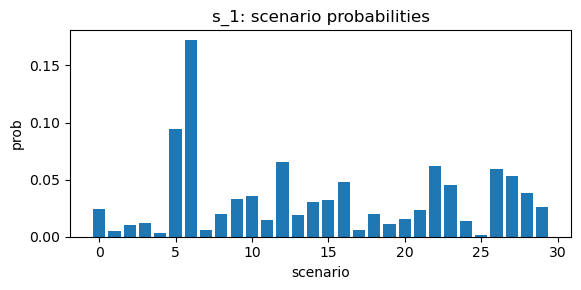

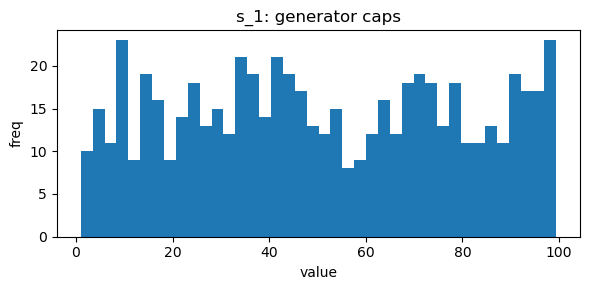

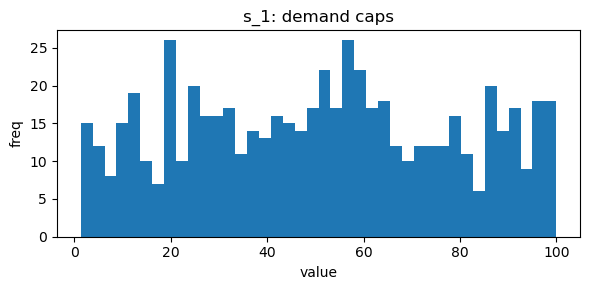

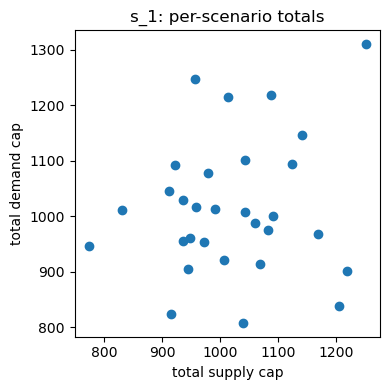

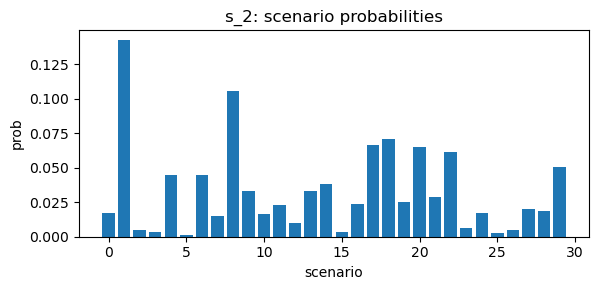

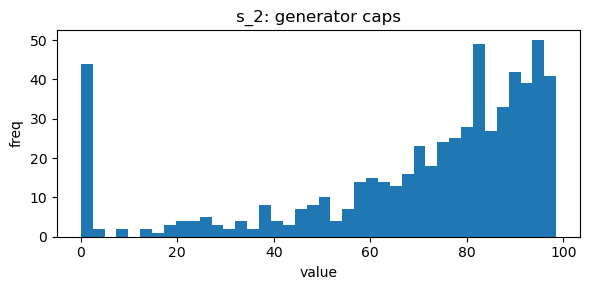

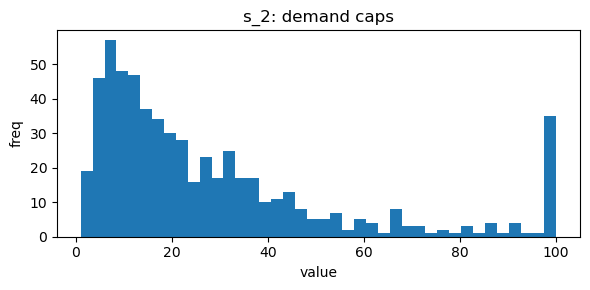

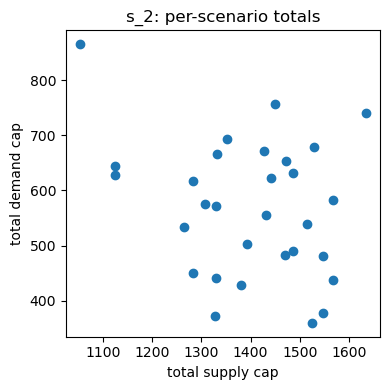

In [4]:
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import jax, jax.numpy as jnp
from jax import random

def plot_probs(probs, title, out):
    plt.figure(figsize=(6,3)); plt.bar(np.arange(len(probs)), probs)
    plt.title(title); plt.xlabel("scenario"); plt.ylabel("prob")
    plt.tight_layout(); plt.savefig(out); plt.show()

def plot_hist(x, title, out, bins=40):
    plt.figure(figsize=(6,3)); plt.hist(x.ravel(), bins=bins)
    plt.title(title); plt.xlabel("value"); plt.ylabel("freq")
    plt.tight_layout(); plt.savefig(out); plt.show()

# removed is_tail entirely
def plot_supply_demand_scatter(g, d, title, out):
    gsum = g.sum(1); dsum = d.sum(1)
    plt.figure(figsize=(4,4)); plt.scatter(gsum, dsum)
    plt.title(title); plt.xlabel("total supply cap"); plt.ylabel("total demand cap")
    plt.tight_layout(); plt.savefig(out); plt.show()

def visualize_scenario(rng, scenario, S=10, G=10, D=10, lo=1.0, hi=100.0, tau=1.0, eps=0.10, outdir=Path("figures")):
    outdir.mkdir(parents=True, exist_ok=True)
    out = sample_instance(rng, scenario, S,G,D,lo,hi,tau,eps)
    probs, mc, mv, g, d = out[:5]  # ignore any extras if present
    tag = f"{scenario}_S{S}_G{G}_D{D}"
    plot_probs(probs, f"{scenario}: scenario probabilities", outdir/f"{tag}_probs.png")
    plot_hist(g, f"{scenario}: generator caps", outdir/f"{tag}_g_hist.png")
    plot_hist(d, f"{scenario}: demand caps", outdir/f"{tag}_d_hist.png")
    plot_supply_demand_scatter(g, d, f"{scenario}: per-scenario totals", outdir/f"{tag}_totals.png")

if __name__=="__main__":
    rng = np.random.default_rng(123)
    scenarios = ["s_1", "s_2"]
    for sc in scenarios:
        visualize_scenario(rng, sc, S=30, G=20, D=20, lo=1.0, hi=100.0, tau=1.0, eps=0.10)

Welfare Plot Distribution

In [5]:
import time
import numpy as np
from jax import random

from zavala_funcs import (
    # stochastic
    zavala,
    zavala_cvar,
    generate_instance,
    price_distortion,
    probability_feasible,
    expected_cumulative_regret,
    # deterministic bits
    zavala_deterministic_da,
    zavala_rt_energy_only,
    expected_caps_from_scenarios,
    # >>> ADDED: printing helpers
    _print_da_rt_summary,
    _stack_rt,
    compute_social_surplus)

# =========================
# Run Zavala baseline (stochastic) + deterministic + CVaR
# =========================
num_instances = 10
key = random.key(200)
keys = random.split(key, num_instances)
instances = []
for key in keys:
    instances.append(generate_instance(key, num_scenarios=1000, num_g=10, num_d=10))

# --- stochastic accumulators ---
zavala_times = []
zavala_distortions = []
zavala_regrets = []
probs_feasible = []

# --- deterministic accumulators ---
det_distortions = []
det_regrets = []

# --- CVaR accumulators ---
cvar_distortions = []
cvar_regrets = []

# --- social-surplus accumulators ---
stoch_ss_neg_total, stoch_ss_neg_supplier, stoch_ss_neg_consumer, stoch_ss = [], [], [], []
det_ss_neg_total,   det_ss_neg_supplier,   det_ss_neg_consumer,   det_ss   = [], [], [], []
cvar_ss_neg_total,  cvar_ss_neg_supplier,  cvar_ss_neg_consumer,  cvar_ss  = [], [], [], []

for i in range(len(instances)):
    probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar = instances[i]

    # # ===== Stochastic Zavala =====
    # # >>> CHANGED: capture Z_G, Z_D instead of discarding
    # z_g_i, z_d_j, Z_G, Z_D, z_pi, z_Pi = zavala(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar)

    # probs_feasible.append(probability_feasible(probs, z_g_i, z_d_j, g_i_bar, d_j_bar))
    # zavala_distortions.append(price_distortion(probs, z_pi, z_Pi))
    # zavala_regrets.append(expected_cumulative_regret(probs, z_g_i, z_d_j, z_pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar))
    # ss_stoch = compute_social_surplus(
    #     probs, mc_g_i, mv_d_j,
    #     g_da=z_g_i, d_da=z_d_j,
    #     G_rt=Z_G, D_rt=Z_D,
    #     # optional: pass custom deltas to match your experiments
    #     # mc_g_i_delta=mc_g_i/10.0, mv_d_j_delta=mv_d_j/10.0
    # )
    # stoch_ss_neg_total.append(ss_stoch["E_neg_total"])
    # stoch_ss_neg_supplier.append(ss_stoch["E_neg_supplier"])
    # stoch_ss_neg_consumer.append(ss_stoch["E_neg_consumer"])
    # stoch_ss.append(ss_stoch["E_social_surplus"])

    # # ===== CVaR Zavala =====
    # # >>> CHANGED: capture C_G, C_D so we can print
    # cvar_g_i, cvar_d_j, C_G, C_D, cvar_pi, cvar_Pi, cvar_link_dual = zavala_cvar(probs, mc_g_i, mv_d_j, g_i_bar, d_j_bar)
    # cvar_distortions.append(price_distortion(probs, cvar_pi, cvar_Pi))
    # cvar_regrets.append(expected_cumulative_regret(probs, cvar_g_i, cvar_d_j, cvar_pi, mc_g_i, mv_d_j, g_i_bar, d_j_bar))
    # ss_cvar = compute_social_surplus(
    #     probs, mc_g_i, mv_d_j,
    #     g_da=cvar_g_i, d_da=cvar_d_j,
    #     G_rt=C_G, D_rt=C_D,
    # )
    # cvar_ss_neg_total.append(ss_cvar["E_neg_total"])
    # cvar_ss_neg_supplier.append(ss_cvar["E_neg_supplier"])
    # cvar_ss_neg_consumer.append(ss_cvar["E_neg_consumer"])
    # cvar_ss.append(ss_cvar["E_social_surplus"])          

    # ===== Deterministic Zavala (energy-only, no network) =====
    # Use expected capacities for DA
    gbar_det, dbar_det = expected_caps_from_scenarios(probs, g_i_bar, d_j_bar)

    # Day-ahead deterministic solve
    g_det, d_det, pi_det = zavala_deterministic_da(mc_g_i, mv_d_j, gbar_det, dbar_det)

    # Real-time per scenario — also collect RT dispatch to print deltas
    G_det_list, D_det_list, Pi_det_list = [], [], []
    for p in range(len(probs)):
        Gp, Dp, Pi_p = zavala_rt_energy_only(mc_g_i, mv_d_j, g_det, d_det, g_i_bar[p], d_j_bar[p])
        G_det_list.append(Gp)
        D_det_list.append(Dp)
        Pi_det_list.append(Pi_p)
    G_det_rt, D_det_rt = _stack_rt(G_det_list, D_det_list)
    Pi_det = np.array(Pi_det_list)

    det_distortions.append(price_distortion(probs, pi_det, Pi_det))
    det_regrets.append(expected_cumulative_regret(probs, g_det, d_det, pi_det, mc_g_i, mv_d_j, g_i_bar, d_j_bar))

    # --- NEW: §4.1 social surplus for deterministic run ---
    ss_det = compute_social_surplus(
        probs, mc_g_i, mv_d_j,
        g_da=g_det, d_da=d_det,
        G_rt=G_det_rt, D_rt=D_det_rt,
        # mc_g_i_delta=mc_g_i/10.0, mv_d_j_delta=mv_d_j/10.0,  # (optional) explicitly pass deltas
    )
    det_ss_neg_total.append(ss_det["E_neg_total"])
    det_ss_neg_supplier.append(ss_det["E_neg_supplier"])
    det_ss_neg_consumer.append(ss_det["E_neg_consumer"])
    det_ss.extend(ss_det["ss_per_scenario"])


# # ============== Overall Expectation Results =================
# print(f'Stochastic Zavala mean distortion: {np.mean(zavala_distortions)}')
# print(f'Stochastic Zavala with CVaR mean distortion: {np.mean(cvar_distortions)}')
# print(f'Deterministic mean distortion: {np.mean(det_distortions)}')

# print(f"Stochastic mean E[-SS]: {np.mean(stoch_ss_neg_total)} "
#       f"(suppliers {np.mean(stoch_ss_neg_supplier)}, consumers {np.mean(stoch_ss_neg_consumer)})")
# print(f"Stochastic mean E[SS]:  {np.mean(stoch_ss)}")

# print(f"CVaR       mean E[-SS]: {np.mean(cvar_ss_neg_total)} "
#       f"(suppliers {np.mean(cvar_ss_neg_supplier)}, consumers {np.mean(cvar_ss_neg_consumer)})")
# print(f"CVaR       mean E[SS]:  {np.mean(cvar_ss)}")

# print(f"Deterministic mean E[-SS]: {np.mean(det_ss_neg_total)} "
#       f"(suppliers {np.mean(det_ss_neg_supplier)}, consumers {np.mean(det_ss_neg_consumer)})")
# print(f"Deterministic mean E[SS]:  {np.mean(det_ss)}")

# print("Stochastic Case \n")
# print(f"Total Welfare = {stoch_ss_neg_total}")
# print(f"Day-ahead price = {z_pi}")
# print(f"Real-time price = {z_Pi}")
# print(f"Probability = {probs} \n")


# print("CVaR Stochastic Case \n")
# print(f"Total Welfare = {cvar_ss_neg_total}")
# print(f"Day-ahead price = {cvar_pi}")
# print(f"Real-time price = {cvar_Pi}")
# print(f"Probability = {probs} \n")

# tail_vals_stoch, tail_probs_stoch = collect_tail_list(stoch_ss_neg_total, probs, tail=0.05)
# tail_vals_cvar,  tail_probs_cvar  = collect_tail_list(cvar_ss_neg_total,  probs, tail=0.05)
# # sanity prints
# print("All stochastic NEG-SS:", np.array(stoch_ss_neg_total))
# print("Tail 5% stochastic NEG-SS:", tail_vals_stoch)
# print("Tail 5% stochastic probs:", tail_probs_stoch, " -> sum =", tail_probs_stoch.sum())

# print("All CVaR NEG-SS:", np.array(cvar_ss_neg_total))
# print("Tail 5% CVaR NEG-SS:", tail_vals_cvar)
# print("Tail 5% CVaR probs:", tail_probs_cvar, " -> sum =", tail_probs_cvar.sum())

# print(f" Mean Stochastic Tail welfare = {np.mean(tail_vals_stoch)}")
# print(f" Mean CVaR Stochastic Tail welfare = {np.mean(tail_vals_cvar)}")



Set parameter Username
Set parameter LicenseID to value 2640729
Academic license - for non-commercial use only - expires 2026-03-21


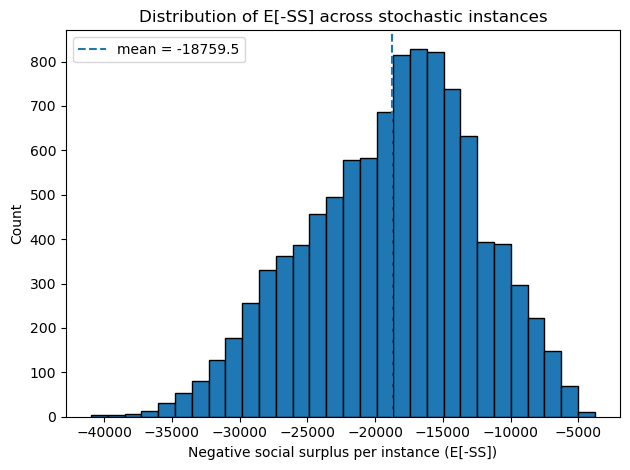

In [6]:
import matplotlib.pyplot as plt
# ---- Plot welfare distribution (negative social surplus E[-SS]) ----
vals = np.array(det_ss, dtype=float)

plt.figure()
plt.hist(vals, bins=30, edgecolor='black')
plt.axvline(vals.mean(), linestyle='--', label=f"mean = {vals.mean():.1f}")
plt.xlabel("Negative social surplus per instance (E[-SS])")
plt.ylabel("Count")
plt.title("Distribution of E[-SS] across stochastic instances")
plt.legend()
plt.tight_layout()

# If you run headless or want a file, save it; otherwise plt.show() is fine.
# plt.savefig("stochastic_neg_ss_distribution.png", dpi=150)
plt.show()